In [133]:
import io
import os
import pickle
from pathlib import Path
import pandas as pd
import torch
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [91]:
def get_last_in_path(path):
    return str(path).split('/')[-1]

In [93]:
run_project_name = 'test_name' # change accordingly
log_path = f'../../Scratch/merged-data/{run_project_name}'

In [202]:
results_path = '../../Scratch/merged-data/results'
images_path = '../../Scratch/merged-data/images'

# Record failure logs?

In [94]:
invalid_runs = dict()

for p in Path(log_path).iterdir():
    file_name = get_last_in_path(p)
    if not file_name.endswith('.txt'): 
        continue
    run_params = file_name[:-4] # abc.txt -> this removes .txt 
    cut = run_params.split('_')[-2].split('.')[-1].split('=')[1]
    
#     # check if valid runs even exist:
#     first_cut = int(cut.split(',')[0])
#     num_succeed = len(results_df[(results_df['first_cut'] == first_cut)])
#     if num_succeed == 0:
#         invalid_runs[cut] = None
#         continue
        
    with open(p, 'r') as f:
        lines = f.readlines()
        invalid_runs[cut] = set()
        if len(lines) > 0:
            # potentially invalid run for this particular run, store all the images which might be potentially invalid
            for line in lines:
                img_name = line.split('  ')[-2].split('.')[0]
                invalid_runs[cut].add(img_name)

In [95]:
import pprint

pprint.pprint({k: (-1 if v is None else len(v)) for k,v in invalid_runs.items()})

{'0,-1': 17,
 '1,-1': 4,
 '10,-1': 29,
 '11,-1': 28,
 '12,-1': 30,
 '13,-1': 29,
 '14,-1': 0,
 '15,-1': 27,
 '2,-1': 0,
 '3,-1': 0,
 '4,-1': 0,
 '5,-1': 0,
 '6,-1': 19,
 '7,-1': 23,
 '8,-1': 25,
 '9,-1': 23}


# Collect data into DataFrame

In [238]:
from collections import defaultdict
d = []
check_list = defaultdict(list)


# Adapted from https://github.com/nik-sm/generator-surgery/blob/master/utils.py#L160 
# because our folder structure is modelled after theirs
for model_path in Path(results_path).iterdir():
    model = get_last_in_path(model_path)
    #print("model:", model)
    for dataset_path in model_path.iterdir():
        dataset = get_last_in_path(dataset_path)
        #print("dataset:", dataset)
        for img_path in dataset_path.iterdir():
            image = get_last_in_path(img_path)
            #print("image:", image)
            for fm_path in img_path.iterdir():
                forward_model = get_last_in_path(fm_path)
                #print("fm:", forward_model)
                for run_path in fm_path.iterdir():
                    run_params = get_last_in_path(run_path)
                    #print("run:", run_params)
                    for cut_path in run_path.iterdir():
                        cut = get_last_in_path(cut_path).split('=')[-1]
                        cut_split = cut[1:-1].split(',')
                        first_cut = int(cut_split[0])
                        second_cut = int(cut_split[1])
                        is_valid=1
                        #print("cut:", cut)
                        try: 
                            with open(cut_path / 'metrics.pkl', 'rb') as f:
                                metrics = pickle.load(f)
                            
                            recovered_img = torch.load(cut_path / 'recovered.pt', map_location=torch.device('cpu'))
                        except FileNotFoundError as err:
                            print('Could not find metrics.pkl from ', cut_path)
                            continue
                            
                        if metrics['TRAIN_MSE'] > 0.01:
                            # for a valid run, train_mse shouldn't be greater than 0.01
                            check_list[cut].append((image, recovered_img))
                            is_valid=0
                            # check the recovered_img
                        
                        row = {
                            'model': model,
                            'dataset': dataset,
                            'image': image,
                            'fm': forward_model,
                            'run': run_params,
                            'cut':cut,
                            'first_cut': first_cut,
                            'second_cut': second_cut,
                            'is_valid': is_valid,
                            **metrics
                        }
                        d.append(row)

                        
results_df = pd.DataFrame(d)

Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=1.z_number=1/cuts=[14, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=1.z_number=1/cuts=[3, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=1.z_number=1/cuts=[5, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=1.z_number=1/cuts=[4, -1]


In [239]:
for cut_idx in range(0,16):
    num_succeed = len(results_df[results_df['first_cut'] == cut_idx])
    cut = f'[{cut_idx}, -1]'
    print(f'==> Results for {cut_idx} had {num_succeed} runs and {len(check_list[cut])}')

==> Results for 0 had 30 runs and 10
==> Results for 1 had 30 runs and 0
==> Results for 2 had 30 runs and 0
==> Results for 3 had 0 runs and 0
==> Results for 4 had 0 runs and 0
==> Results for 5 had 0 runs and 0
==> Results for 6 had 30 runs and 3
==> Results for 7 had 30 runs and 3
==> Results for 8 had 30 runs and 11
==> Results for 9 had 30 runs and 6
==> Results for 10 had 30 runs and 6
==> Results for 11 had 30 runs and 16
==> Results for 12 had 30 runs and 29
==> Results for 13 had 30 runs and 29
==> Results for 14 had 0 runs and 0
==> Results for 15 had 30 runs and 27


# Show failures

In [240]:
def show_failures(cut):
    failures = check_list['[' + cut + ']'].copy()
    num_failures = len(failures)
    
    print(f'Testing {cut}')
    print('Num failures: ', num_failures)

    nrows = max(1,num_failures // 3)
    ncols = math.ceil(num_failures / nrows)

    if ncols == 0:
        print('No failures')
        return

    print(f'Rows: {nrows}\tCols:{ncols}')

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
    fig.tight_layout()

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx == num_failures:
                break
            img_name = failures[idx][0]
            
            img = failures[idx][1] 
            if nrows == 1 or ncols == 1:
                ax[idx].set_title(img_name)
                ax[idx].imshow(img.permute(1,2,0))
            else:
                ax[row][col].set_title(img_name)
                ax[row][col].imshow(img.permute(1,2,0))
            
    plt.show()

In [241]:
check_cut = '10, -1' # change accordingly

Testing 10, -1
Num failures:  6
Rows: 2	Cols:3


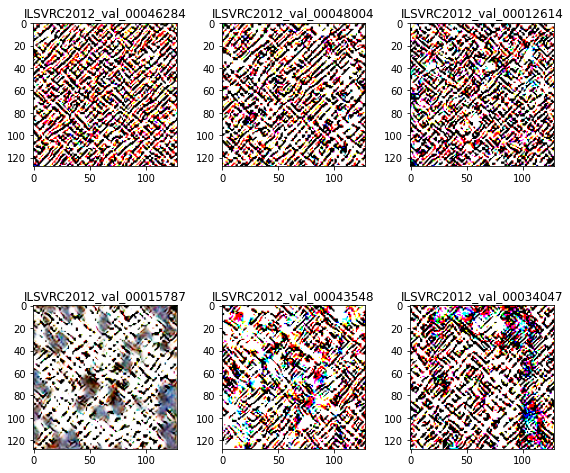

In [242]:
show_failures(check_cut)

## Count number of failures for each image to decide which ones to remove

In [254]:
failed_images = defaultdict(int)

for cut, entries in check_list.items():
    for (img_name, img_tensor) in entries:
        failed_images[img_name] += 1


In [255]:
failed_images

defaultdict(int,
            {'ILSVRC2012_val_00026848': 3,
             'ILSVRC2012_val_00038034': 7,
             'ILSVRC2012_val_00006509': 6,
             'ILSVRC2012_val_00013809': 6,
             'ILSVRC2012_val_00046284': 6,
             'ILSVRC2012_val_00048004': 6,
             'ILSVRC2012_val_00032644': 4,
             'ILSVRC2012_val_00043548': 6,
             'ILSVRC2012_val_00030496': 5,
             'ILSVRC2012_val_00011584': 5,
             'ILSVRC2012_val_00028807': 6,
             'ILSVRC2012_val_00027330': 2,
             'ILSVRC2012_val_00003530': 4,
             'ILSVRC2012_val_00034228': 3,
             'ILSVRC2012_val_00007544': 6,
             'ILSVRC2012_val_00012512': 6,
             'ILSVRC2012_val_00019878': 3,
             'ILSVRC2012_val_00012614': 4,
             'ILSVRC2012_val_00015787': 6,
             'ILSVRC2012_val_00036303': 4,
             'ILSVRC2012_val_00011420': 3,
             'ILSVRC2012_val_00037863': 4,
             'ILSVRC2012_val_00034002

# Analyze results

In [249]:
metrics = ['TRAIN_MSE', 'ORIG_MSE', 'ORIG_PSNR', 'ORIG_LPIPS', 'ORIG_SSIM', 'time_taken']

In [250]:
# Rank cuts by PSNR 
results_df.groupby('cut').sum()[metrics].sort_values(by='ORIG_PSNR', ascending=False)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken
cut,,,,,,
"[2, -1]",0.006037,0.176563,693.756584,8.072237,20.631464,308.315170
"[1, -1]",0.018960,0.281256,665.498959,10.666579,18.960775,304.865634
"[6, -1]",0.112969,1.393098,550.956906,13.156841,15.910239,110.473489
"[9, -1]",0.194623,2.258545,483.276752,16.351567,12.026793,142.484235
"[7, -1]",0.096546,1.418170,470.721445,16.543206,12.592350,159.720873
"[10, -1]",0.195783,2.468203,430.372375,18.668770,10.135138,145.642193
"[8, -1]",0.280926,3.108462,409.471856,17.141151,11.389384,216.492970
"[0, -1]",0.420407,4.227703,358.605767,22.482453,8.293924,132.983532
"[11, -1]",0.382015,4.113390,342.142502,20.717269,6.312060,146.570838


In [251]:
results_df.groupby('cut').sum()[metrics].sort_values(by='ORIG_LPIPS', ascending=True)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken
cut,,,,,,
"[2, -1]",0.006037,0.176563,693.756584,8.072237,20.631464,308.315170
"[1, -1]",0.018960,0.281256,665.498959,10.666579,18.960775,304.865634
"[6, -1]",0.112969,1.393098,550.956906,13.156841,15.910239,110.473489
"[9, -1]",0.194623,2.258545,483.276752,16.351567,12.026793,142.484235
"[7, -1]",0.096546,1.418170,470.721445,16.543206,12.592350,159.720873
"[8, -1]",0.280926,3.108462,409.471856,17.141151,11.389384,216.492970
"[10, -1]",0.195783,2.468203,430.372375,18.668770,10.135138,145.642193
"[11, -1]",0.382015,4.113390,342.142502,20.717269,6.312060,146.570838
"[0, -1]",0.420407,4.227703,358.605767,22.482453,8.293924,132.983532


In [252]:
results_df.groupby('cut').sum()[metrics].sort_values(by='ORIG_SSIM', ascending=False)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken
cut,,,,,,
"[2, -1]",0.006037,0.176563,693.756584,8.072237,20.631464,308.315170
"[1, -1]",0.018960,0.281256,665.498959,10.666579,18.960775,304.865634
"[6, -1]",0.112969,1.393098,550.956906,13.156841,15.910239,110.473489
"[7, -1]",0.096546,1.418170,470.721445,16.543206,12.592350,159.720873
"[9, -1]",0.194623,2.258545,483.276752,16.351567,12.026793,142.484235
"[8, -1]",0.280926,3.108462,409.471856,17.141151,11.389384,216.492970
"[10, -1]",0.195783,2.468203,430.372375,18.668770,10.135138,145.642193
"[0, -1]",0.420407,4.227703,358.605767,22.482453,8.293924,132.983532
"[11, -1]",0.382015,4.113390,342.142502,20.717269,6.312060,146.570838
